In [92]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [93]:
BASE_DIR = 'data_feed/'
# Set the hyperparameters
HIDDEN_SIZE = 32
NUM_EPOCHS = 100
LAG = 10
N_STOCK = 20
BATCH_SIZE = 32
NUM_LAYERS = 2
NUM_HEADS = 1
DROPOUT = 0.1

# Definition of the models and functions

In [94]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, (h_n, c_n) = self.lstm(x)
        out = self.fc(out)
        return out, (h_n, c_n)

In [112]:
class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, num_heads, dropout):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_size, hidden_size)
        self.transformer = nn.Transformer(
            d_model=hidden_size,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=hidden_size,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x, x)
        x = self.fc(x)
        return x, _


In [116]:
def training(data: DataLoader, model, criterion, optimizer, input_size):
    # Training loop
    running_loss = 0.
    last_loss = 0.

    for epoch in range(NUM_EPOCHS):
        for i, batch in enumerate(data):
            X, y = batch
            predict, _ = model(X)
            loss = criterion(predict, y)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        if (epoch + 1) % 10 == 0:
            last_loss = running_loss/10
            print(f'Epoch: {epoch + 1}/{NUM_EPOCHS}, Loss: {last_loss}')
            running_loss = 0


def testing(data: DataLoader, model):
    # Generate predictions
    model.eval()
    predictions = []
    with torch.no_grad():
        for i, batch in enumerate(data):
            X, y = batch
            predict, _ = model(X)
            predictions.append(predict.detach().numpy())
    
    return predictions


# Data Preprocessing

In [97]:
# check if data_feed directory exist if not 
assert os.path.exists(BASE_DIR)
# list all the files in the data_feed directory
files = os.listdir('data_feed/')

# Data Processing for the model

In [98]:
def rename_columns(df: pd.DataFrame, file_name: str) -> None:
    """
    modify columns names (exept date) into the following structure: 
        *column_name*_*stock_name* 
        
    Example: Open_AAPL
    """
    df.rename(columns=dict(zip(df.columns[1:], df.columns[1:] + '_' + file_name[:-4])), inplace=True)

In [99]:
device = torch.device("cpu")
#if torch.cuda.is_available():
#    device = torch.device("cuda")

In [100]:
# Read First File into a pandas dataframe
df = pd.read_csv(BASE_DIR+files[0])
rename_columns(df, files[0])

# Merge Everything into a unique DataFrame
for fn in files[1:]:
    df2 = pd.read_csv(BASE_DIR+fn)
    rename_columns(df2, fn)
    result = df.merge(df2, on='Date')
    df = result

df.set_index('Date',inplace=True)
df.index = pd.to_datetime(df.index)

In [101]:
cols = [col for col in df.columns if "Adj Close" in col]
df = df[cols]


# Save all the data onto a file
#df.to_csv('AGGREGATED_DATA.csv')

In [102]:
split_date = df.index[0] + pd.offsets.DateOffset(years=8)
train_data = df[df.index <= split_date]
test_data = df[df.index > split_date]
#test_data.to_csv('TEST.csv')
#train_data.to_csv('TRAIN.csv')

In [103]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_data.values)
scaled_test = scaler.transform(test_data.values)

In [108]:
class TimeSeriesdataset(Dataset):
    def __init__(self, lag: int, data: np.ndarray, device: torch.device):
        self.lag = lag
        self.data = data
        self.device = device

    def __len__(self):
        lenght = len(self.data)
        return lenght - (self.lag + 1)

    def __getitem__(self, idx):
        X = self.data[idx:idx+self.lag, :].flatten()
        Y = self.data[idx+self.lag, :]
        return torch.Tensor(X, device=self.device), torch.Tensor(Y, device=self.device)

In [109]:
train_dataset = TimeSeriesdataset(lag=LAG, data=scaled_train, device=device)
test_dataset = TimeSeriesdataset(lag=LAG, data=scaled_test, device=device)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Model, training and testing

In [113]:
# Create the LSTM model
modelLSTM = LSTM(input_size=LAG*N_STOCK, hidden_size=HIDDEN_SIZE, output_size=N_STOCK).to(device)
modelTransformer = TransformerModel(input_size=LAG*N_STOCK, hidden_size=HIDDEN_SIZE, output_size=N_STOCK, num_layers=NUM_LAYERS, num_heads=NUM_HEADS, dropout=DROPOUT).to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizerLSTM = optim.Adam(modelLSTM.parameters())
optimizerTransformer = optim.Adam(modelTransformer.parameters())

In [ ]:
print(type(train_dataloader))

In [114]:
LSTM_train = training(train_dataloader, modelLSTM, criterion, optimizerLSTM, input_size=LAG*N_STOCK)
Transformer_train = training(train_dataloader, modelTransformer, criterion, optimizerTransformer, input_size=LAG*N_STOCK)

Epoch: 10/100, Loss: 0.7683237662422471
Epoch: 20/100, Loss: 0.2798117361322511
Epoch: 30/100, Loss: 0.23005893900990487
Epoch: 40/100, Loss: 0.14573327463003807
Epoch: 50/100, Loss: 0.15314953231718392
Epoch: 60/100, Loss: 0.21045458574662917
Epoch: 70/100, Loss: 0.2090166658977978
Epoch: 80/100, Loss: 0.2042334424564615
Epoch: 90/100, Loss: 0.17296836966997944
Epoch: 100/100, Loss: 0.1601180395227857
Epoch: 10/100, Loss: 3.684241960942745
Epoch: 20/100, Loss: 1.412418234301731
Epoch: 30/100, Loss: 0.7168894745642319
Epoch: 40/100, Loss: 0.5649574492592364
Epoch: 50/100, Loss: 0.4689502214198001
Epoch: 60/100, Loss: 0.4725100449286401
Epoch: 70/100, Loss: 0.38971173560712485
Epoch: 80/100, Loss: 0.4550833996967413
Epoch: 90/100, Loss: 0.4432990854489617
Epoch: 100/100, Loss: 0.46807727179257197


In [117]:
LSTM_test = testing(test_dataloader, modelLSTM)
Transformer_test = testing(test_dataloader, modelTransformer)

# Plots

In [118]:
def plotting(predictions):
    # join everything into a unique matrix
    all_pred = np.zeros(N_STOCK)
    for b in predictions:
        for p in b:
            all_pred = np.vstack((all_pred, p))
    # Remove zero vector
    all_pred = all_pred[1:, :]
    all_pred = scaler.inverse_transform(all_pred)

    all_real = np.concatenate((scaled_train, scaled_test))
    all_real = scaler.inverse_transform(all_real)
    all_real.shape[0]

    # idx = 0
    for idx, file_name in enumerate(files):
        stock = file_name[:-4]
        index_test_start = all_real[:, 0].shape[0] - all_pred.shape[0]
        plt.figure()
        plt.plot( range(all_real.shape[0]) , all_real[:, idx], label='real')
        plt.plot( range(index_test_start,all_real.shape[0]), all_pred[:, idx], color='orange', label='forecast')
        plt.axvline(x=index_test_start, color='red', linestyle='--')
        plt.title(stock)
        plt.legend()
        plt.show()


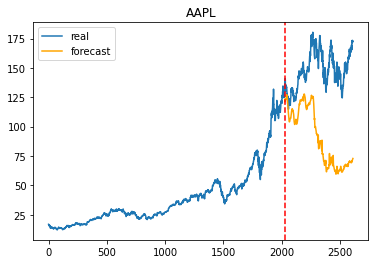

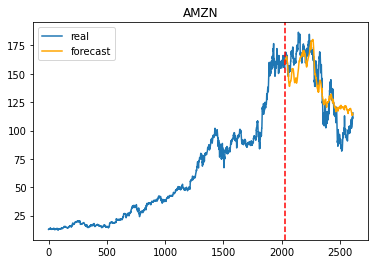

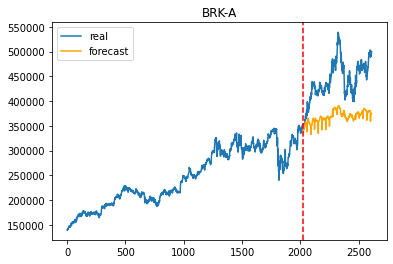

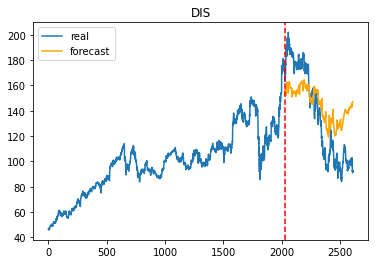

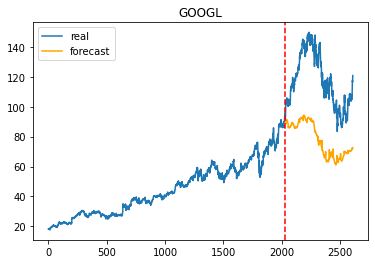

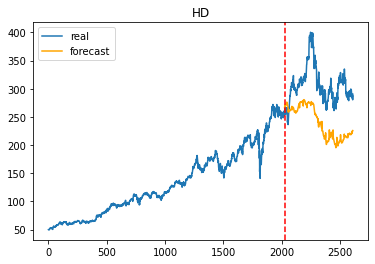

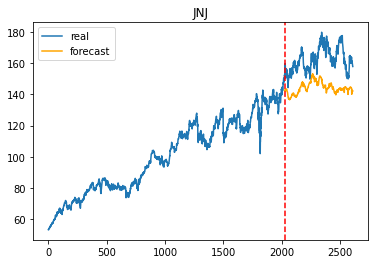

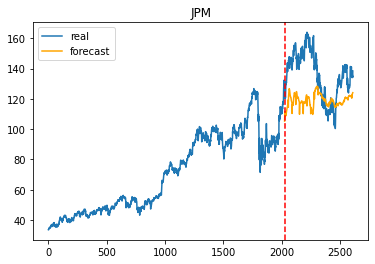

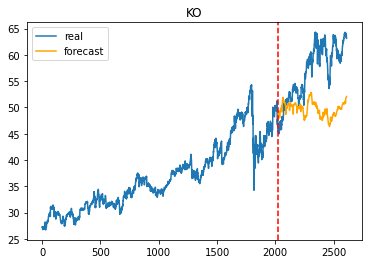

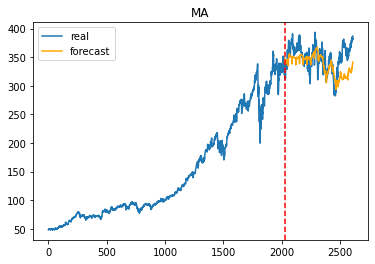

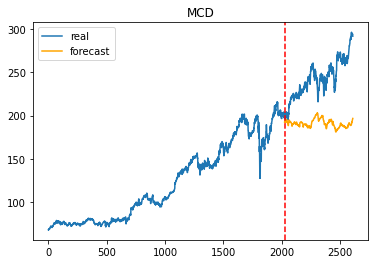

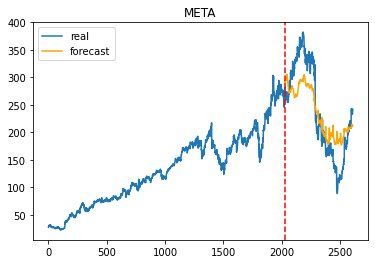

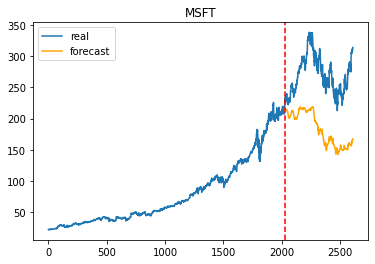

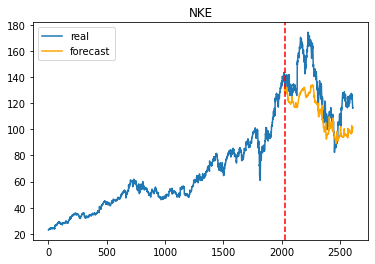

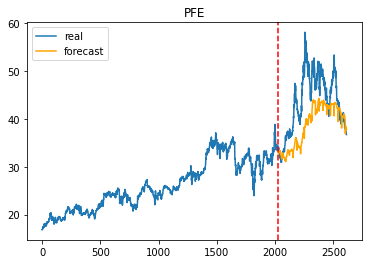

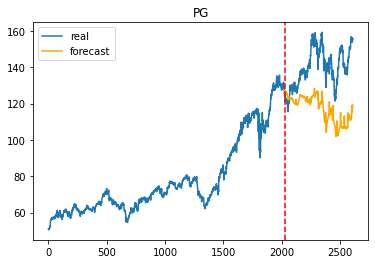

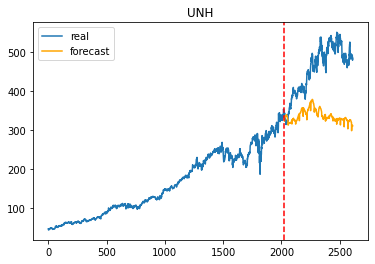

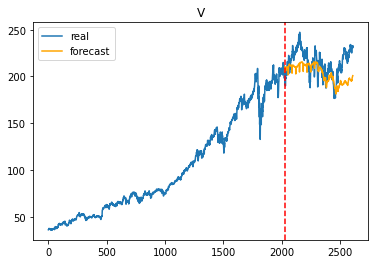

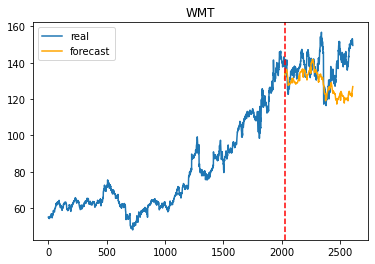

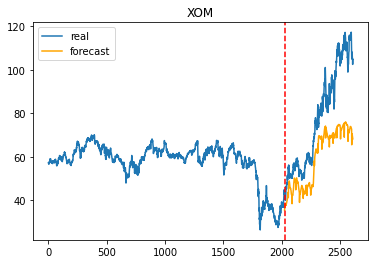

In [119]:
plotting(LSTM_test)

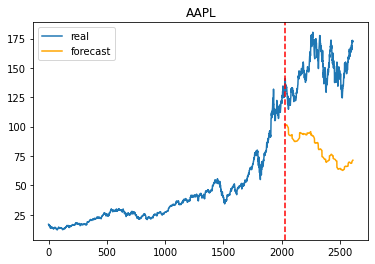

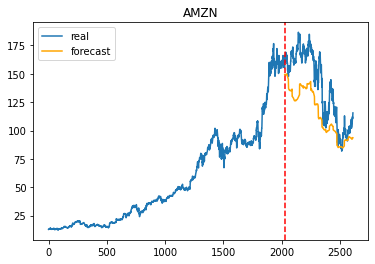

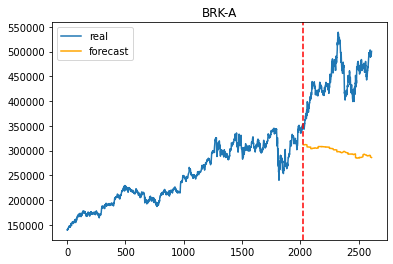

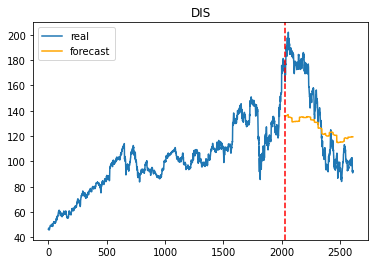

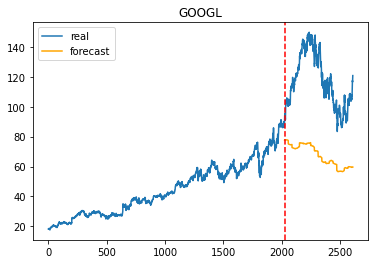

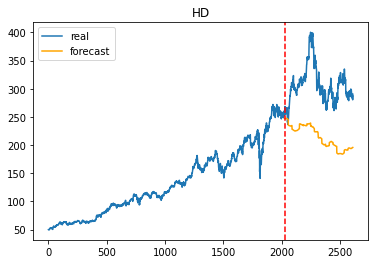

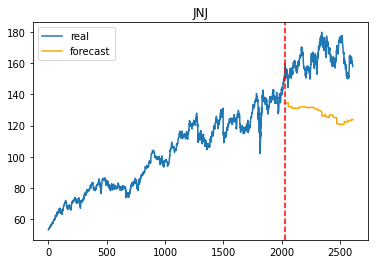

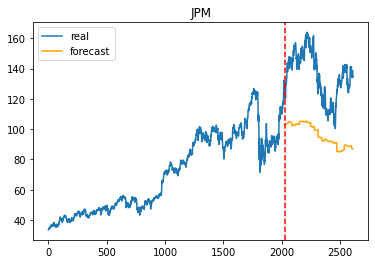

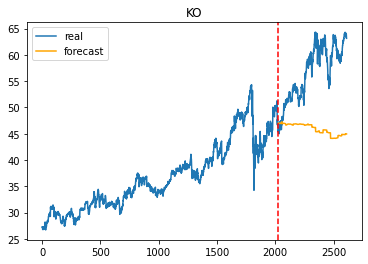

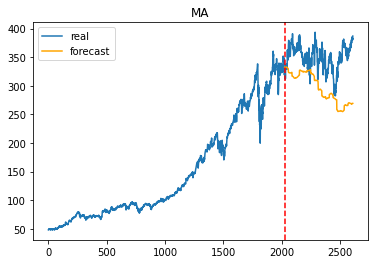

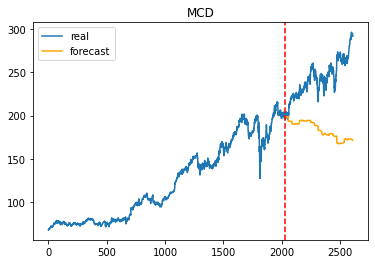

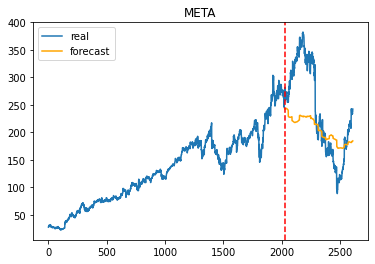

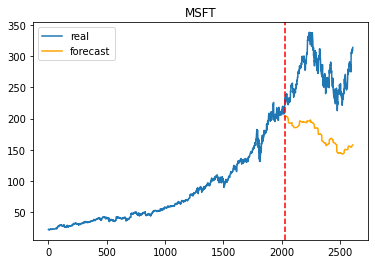

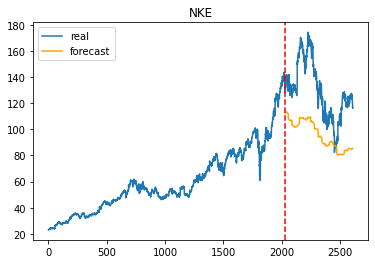

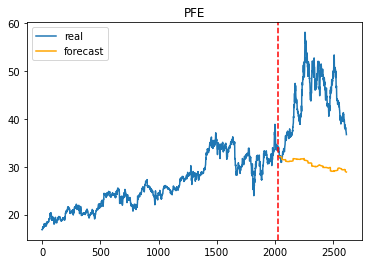

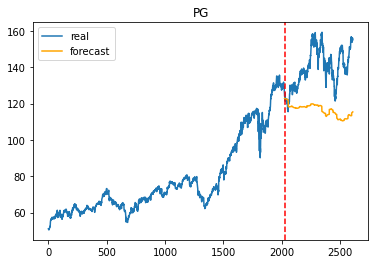

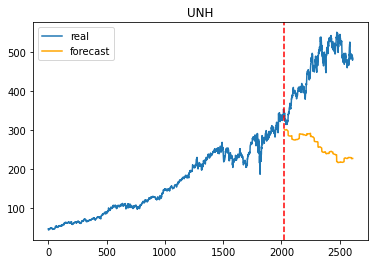

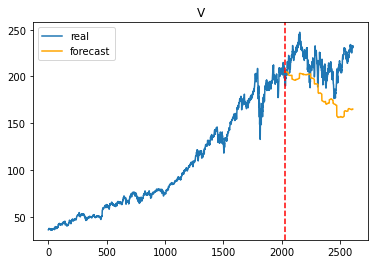

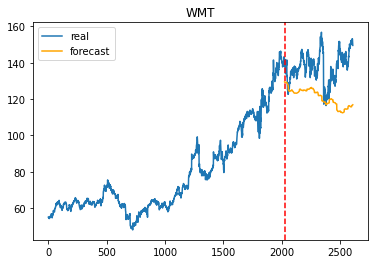

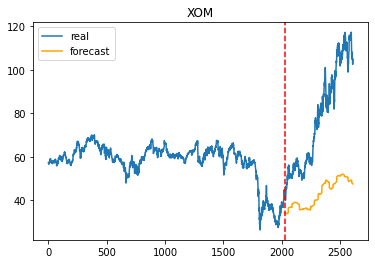

In [120]:
plotting(Transformer_test)